In [1]:
import pandas as pd
from google.colab import files

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
uploaded = files.upload()

Saving ICT_Subdimension_Dataset.csv to ICT_Subdimension_Dataset.csv


**1. Подключим библиотеки, которые потребуются для загрузки и
первичного анализа данных**

In [ ]:
%matplotlib inline
data_source = 'iris.data'
d = pd.read_table(data_source, delimiter=',', header=None,
names=['sepal_length','sepal_width',
'petal_length', 'petal_width','answer'])
# Содержит только первые четыре столбца (индексы 0, 1, 2 и 3)
dX = d.iloc[ : , 0:4 ]
# Сохраняет целевую переменную
dy = d['answer']
print(dX.head())
print(dy.head())

   sepal_length  sepal_width  petal_length  petal_width
0           5.1          3.5           1.4          0.2
1           4.9          3.0           1.4          0.2
2           4.7          3.2           1.3          0.2
3           4.6          3.1           1.5          0.2
4           5.0          3.6           1.4          0.2
0    Iris-setosa
1    Iris-setosa
2    Iris-setosa
3    Iris-setosa
4    Iris-setosa
Name: answer, dtype: object


**2. Для построения дерева классификации воспользуемся
специальным классом sklearn.tree.DecisionTreeClassifier. Оценими точность
модели методом hold-out (рис. 4.2). Следует обратить внимание, что если в
методе ближайших соседей производилась оптимизация по одному параметру
K – количеству ближайших соседей, то при создании модели
DecisionTreeClassifier необходимо указать два параметра: максимальную
глубину дерева (max_depth) и количество признаков разделения дерева
(max_features).**

In [ ]:
# Класс для построения классификатора на основе решения дерева (decision tree)
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
# Функция для вычисления точности классификатора,
# т.е. насколько правильно классификатор предсказал метки для тестовых данных.
from sklearn.metrics import accuracy_score

#Подмножества для hold-out
X_train, X_holdout, y_train, y_holdout = \
train_test_split(dX, dy, test_size=0.3, random_state=12)

# Обучение модели
# Создание экземпляра классификатора на основе дерева решений с параметрами
tree = DecisionTreeClassifier(max_depth=5,
random_state=21,
max_features=2)
tree.fit(X_train, y_train)
#Получение оценки hold-out
tree_pred = tree.predict(X_holdout)
accur = accuracy_score(y_holdout, tree_pred)
print(accur)

0.9777777777777777


**3. Произведем оценку точности модели по методу cross validation
(рис. 4.3), а также сделаем выводы об оптимальном значении параметра
max_depth.**

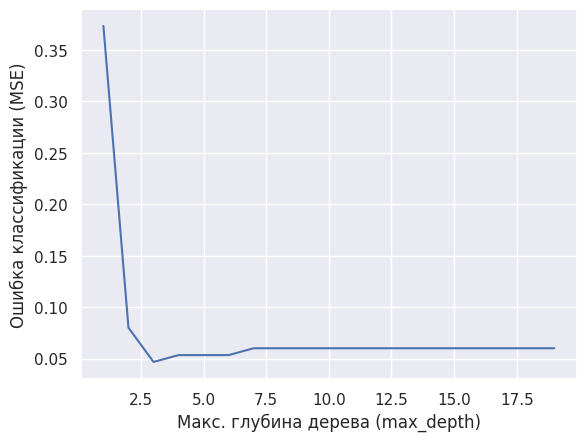

Оптимальные значения max_depth:  [3]


In [ ]:
from sklearn.model_selection import cross_val_score
#Значения параметра max_depth
d_list = list(range(1,20))
# Пустой список для хранения значений точности
cv_scores = []
# В цикле проходим все значения К
for d in d_list:
  tree = DecisionTreeClassifier(max_depth=d,
                            random_state=21,
                            max_features=2)
  scores = cross_val_score(tree, dX, dy, cv=10, scoring='accuracy')
  cv_scores.append(scores.mean())
# Вычисляем ошибку (misclassification error)
MSE = [1-x for x in cv_scores]
# Строим график
plt.plot(d_list, MSE)
plt.xlabel('Макс. глубина дерева (max_depth)');
plt.ylabel('Ошибка классификации (MSE)')
plt.show()

# Ищем минимум
d_min = min(MSE)

# Пробуем найти прочие минимумы (если их несколько)
all_d_min = []
for i in range(len(MSE)):
  if MSE[i] <= d_min:
      all_d_min.append(d_list[i])
# печатаем все К, оптимальные для модели
print('Оптимальные значения max_depth: ', all_d_min)

**4. Оптимальное значение параметра max_depth модели получено, но
в модели присутствует еще один параметр max_features, который был
установлен в значение 2 (не изменялся и не оптимизировался). Для проведения
cross validation по всем параметрам воспользуемся классом GridSearchCV
пакета sklearn.model_selection (рис. 4.5)**

In [ ]:
# GridSearchCV — класс для нахождения оптимальных параметров для модели, перебирая все возможные комбинации в заданном диапазоне.
from sklearn.model_selection import GridSearchCV, cross_val_score
# Модуль, содержащий дерево решений
from sklearn import tree

# Создается классификатор дерева решений с фиксированными параметрами
# Но дальше подбор параметров будет проводиться через GridSearchCV
dtc = DecisionTreeClassifier(max_depth=10, random_state=21, max_features=2)

# Это словарь, который задает диапазоны значений для двух гиперпараметров
tree_params = { 'max_depth': range(1,20), 'max_features': range(1,4) }
# GridSearchCV — выполняет перебор всех возможных комбинаций параметров, указанных в tree_params, и оценивает модель с каждым сочетанием через 10-кратную кросс-валидацию
tree_grid = GridSearchCV(dtc, tree_params, cv=10, verbose=True, n_jobs=-1)
# Обучение модели с использованием кросс-валидации
tree_grid.fit(dX, dy)

print('\n')
# Выводит параметры, которые дали наилучший результат при кросс-валидации
print('Лучшее сочетание параметров: ', tree_grid.best_params_)
# выводит наилучший результат (среднюю точность) кросс-валидации для оптимальных параметров.
print('Лучшие баллы cross validation: ', tree_grid.best_score_)

# Генерируем графическое представление дерева
tree.export_graphviz(tree_grid.best_estimator_,
                     feature_names=dX.columns,
                     class_names=dy.unique(),
                     out_file='iris_tree.dot',
                     filled=True, rounded=True)

Fitting 10 folds for each of 57 candidates, totalling 570 fits


Лучшее сочетание параметров:  {'max_depth': 2, 'max_features': 3}
Лучшие баллы cross validation:  0.9533333333333334


**5. Оптимальные параметры определены, можно обучить модель и
использовать ее для классификации (рис. 4.7).**


In [ ]:
# Построим области решения для оптимального дерева
# max_features = 2, max_depth = 3
dtc = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
dtc.fit(dX, dy)
res = dtc.predict(pd.DataFrame([[5.1, 3.5, 1.4, 0.2]], columns=dX.columns))
print(res)


['Iris-setosa']


**6. В заключении построим еще одну визуализацию процесса
логической классификации – покажем решающие границы модели
классификации (рис. 4.8).**

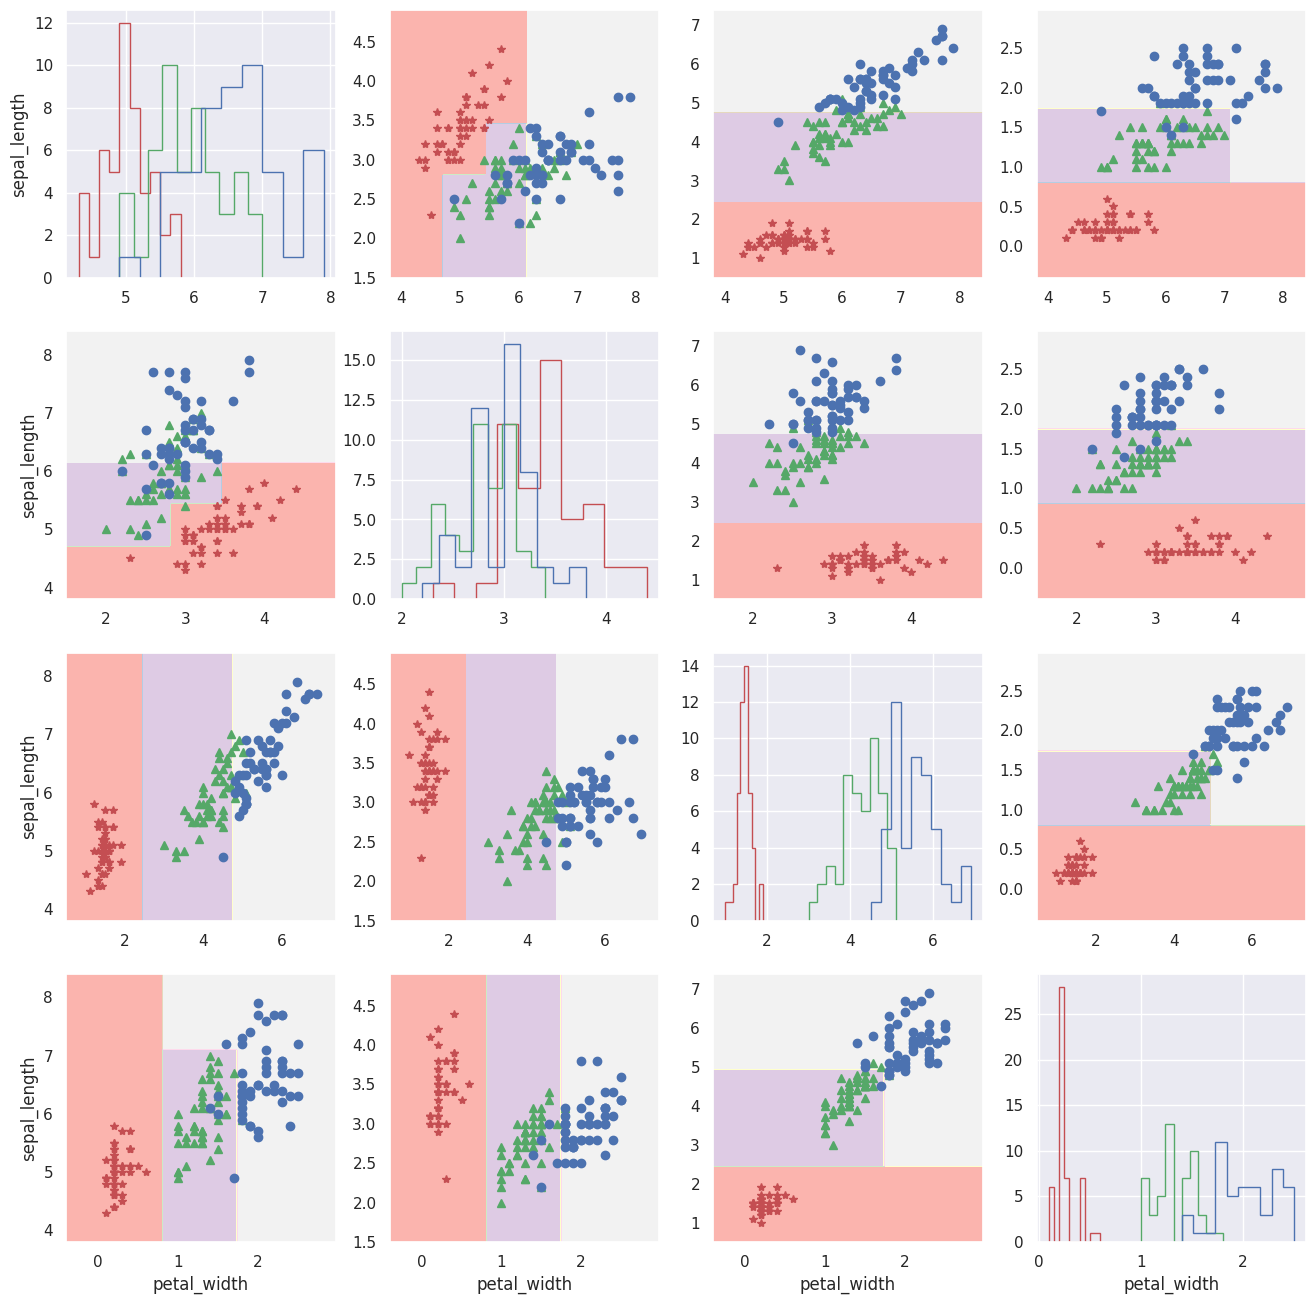

In [ ]:
# plot_markers — список маркеров для различных классов
plot_markers = ['r*', 'g^', 'bo']
# answers — уникальные значения целевой переменной dy
answers = dy.unique()

# Создаем подграфики для каждой пары признаков
# Создается сетка подграфиков 4x4, где каждый подграфик будет представлять собой график для пары признаков.
f, places = plt.subplots(4, 4, figsize=(16, 16))
# Определяются минимальные и максимальные значения признаков с небольшим запасом, чтобы графики не были сжаты.
fmin = dX.min() - 0.5
fmax = dX.max() + 0.5
# Шаг сетки для построения решающих границ модели.
plot_step = 0.02

# Перебираем все возможные пары признаков (всего 4 признака), и для каждой пары создаем подграфик.
for i in range(0, 4):
    for j in range(0, 4):

        # Строим решающие границы
        # Избегаем диагональных подграфиков, где переменные будут одинаковыми.
        if i != j:
          # Генерируем сетку точек для двух признаков, по которым мы хотим построить решающие границы.
            xx, yy = np.meshgrid(
                np.arange(fmin.iloc[i], fmax.iloc[i], plot_step),
                np.arange(fmin.iloc[j], fmax.iloc[j], plot_step)
            )
            # Создаем модель дерева решений с ограничением на максимальную глубину (max_depth=3) и ограничением на количество признаков для использования (max_features=2).
            model = DecisionTreeClassifier(max_depth=3, random_state=21, max_features=2)
            #  Обучаем дерево решений на данных, содержащих только два выбранных признака
            model.fit(dX.iloc[:, [i, j]], dy)

            # Создание DataFrame для предсказаний модели на сетке xx, yy с именами столбцов.
            # Создаем DataFrame для точек сетки, которые будут использоваться для предсказания.
            grid_points = pd.DataFrame(
                np.c_[xx.ravel(), yy.ravel()],
                columns=[dX.columns[i], dX.columns[j]]
            )
            # Предсказываем классы для каждой точки в сетке.
            p = model.predict(grid_points)

            # Преобразование классов в числовые значения
            p_numeric = np.zeros_like(p, dtype=int)
            for idx, label in enumerate(answers):
                p_numeric[p == label] = idx

            p_numeric = p_numeric.reshape(xx.shape)
            #  Рисуем контуры (решающие границы) для каждого подграфика, используя результат предсказания.
            places[i, j].contourf(xx, yy, p_numeric, cmap='Pastel1')

        # Обход всех классов (видов ириса)
        for id_answer in range(len(answers)):
          #  Находим индексы объектов, принадлежащих текущему классу.
            idx = np.where(dy == answers[id_answer])
            # Если текущие признаки совпадают (диагональные подграфики), рисуем гистограмму для каждого класса.
            if i == j:
                places[i, j].hist(
                    dX.iloc[idx].iloc[:, i],
                    color=plot_markers[id_answer][0],
                    histtype='step'
                )
                # Если признаки разные, рисуем точки для каждого класса на соответствующем подграфике с маркерами.
            else:
                places[i, j].plot(
                    dX.iloc[idx].iloc[:, i],
                    dX.iloc[idx].iloc[:, j],
                    plot_markers[id_answer],
                    label=answers[id_answer],
                    markersize=6
                )

        # Подписи осей
        if j == 0:
            places[i, j].set_ylabel(dX.columns[j]) # Подпись оси Y для текущего признака.
        if i == 3:
            places[i, j].set_xlabel(dX.columns[i]) # Подпись оси X для текущего признака.


**ИНДИВИДУАЛЬНОЕ ЗАДАНИЕ**

**Подготовка данных**

In [3]:
from sklearn import tree

# Загрузка файла
data_source = 'ICT_Subdimension_Dataset.csv'
data = pd.read_csv(data_source)

# Выбор интересующих колонок
selected_columns = [
    'City',
    'Year',
    'Household Internet Access (%)',
    'Fixed Broadband Subscriptions (%)',
    'Smart Water Meters (%)',
    'Smart Electricity Meters (%)',
    'Availability of WIFI in Public Areas (count)'
]
subset_data = data[selected_columns]

# Разделение данных на признаки (X) и целевой признак (y)
X = subset_data.iloc[:, 1:]  # Признаки начиная с 3-й колонки
y = subset_data['City']  # Целевой признак

# Проверка данных
print(X.head())
print(y.head())

   Year  Household Internet Access (%)  Fixed Broadband Subscriptions (%)  \
0  2019                          79.45                              48.00   
1  2019                          88.62                              54.70   
2  2019                          79.10                              47.53   
3  2019                          86.82                              60.00   
4  2019                          80.84                              48.03   

   Smart Water Meters (%)  Smart Electricity Meters (%)  \
0                   33.30                         43.40   
1                   38.33                         31.03   
2                   21.98                         37.43   
3                   26.13                         40.12   
4                   28.01                         31.51   

   Availability of WIFI in Public Areas (count)  
0                                           137  
1                                           149  
2                               

**ПОИСК ОПТИМАЛЬНЫХ ЗНАЧЕНИЙ max_depth и features:**

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import graphviz

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Параметры дерева
max_depth = 5
max_features = 3

# Построение дерева
tree_clf = DecisionTreeClassifier(max_depth=max_depth, max_features=max_features, random_state=42)
tree_clf.fit(X_train, y_train)

# Визуализация дерева
dot_data = export_graphviz(
    tree_clf, out_file=None,
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True, rounded=True,
    special_characters=True
)
graph = graphviz.Source(dot_data)
graph.render("decision_tree", format="png")  # Сохранение дерева в формате PNG
print("Дерево сохранено в формате PNG.")

Дерево сохранено в формате PNG.


**Вычисление оценки cross-validation (MSE) для разных значений max_depth**

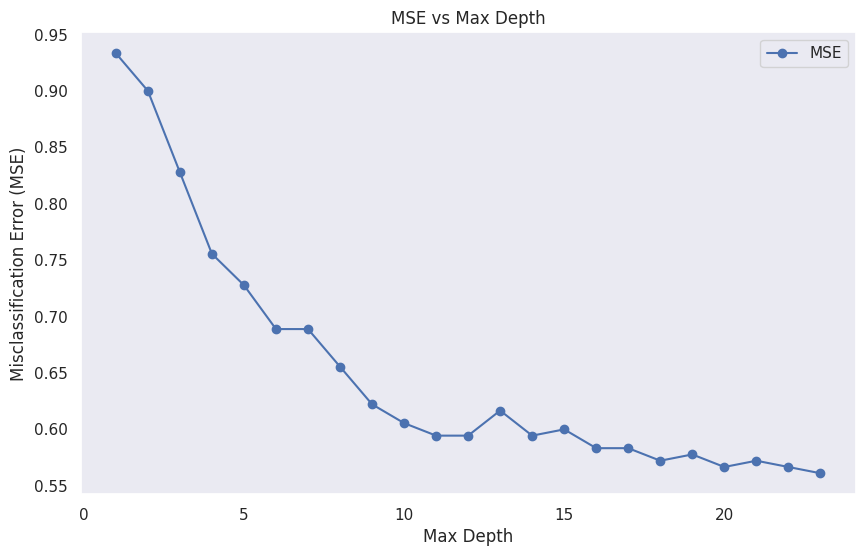

In [9]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

# Тестирование разных значений max_depth
depth_range = range(1, 24) # диапазон значений max_depth 1-20
mse_scores_depth = [] # список хранения средних значений ошибки классификации (MSE) для каждой глубины

# перебираем все значения max_depth из заданного диапазона.
for depth in depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, max_features=max_features, random_state=42)
    # Оцениваем точность модели на кросс-валидации с 6 фолдами
    scores = cross_val_score(clf, X, y, cv=6, scoring='accuracy')
    # #Вычисляем среднюю ошибку классификации (MSE), которая равна Accuracy MSE=1−Accuracy.
    mse_scores_depth.append(1 - scores.mean())

# График зависимости MSE от max_depth
plt.figure(figsize=(10, 6))
plt.plot(depth_range, mse_scores_depth, marker='o', label="MSE")
plt.xlabel('Max Depth')
plt.ylabel('Misclassification Error (MSE)')
plt.title('MSE vs Max Depth')
plt.legend() # добавляем легенду (для графика MSE).
plt.grid()
plt.show()


**Вычисление оценки cross-validation (MSE) для разных значений max_features (пункт 2.3)**


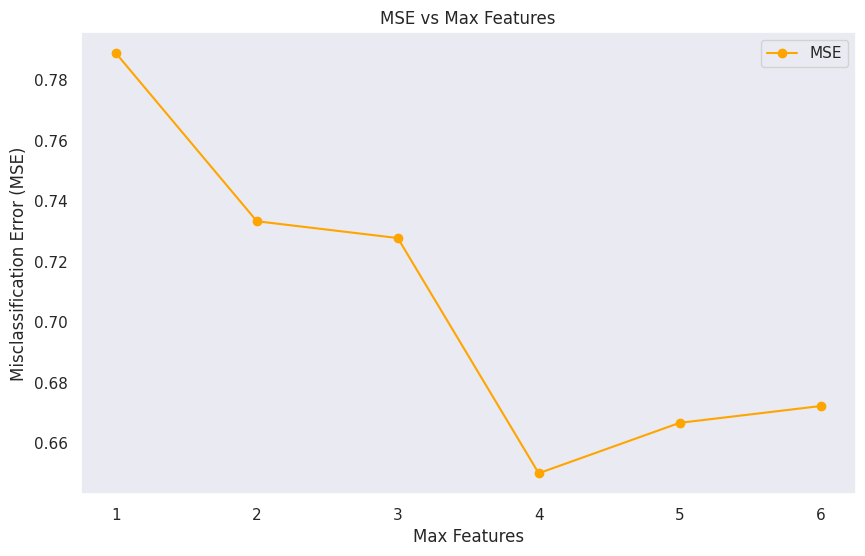

In [6]:
# Тестирование разных значений max_features
features_range = range(1, X.shape[1] + 1) # X.shape[1] — общее количество признаков в наборе данных.
mse_scores_features = []

for features in features_range:
    clf = DecisionTreeClassifier(max_depth=max_depth, max_features=features, random_state=42)
    scores = cross_val_score(clf, X, y, cv=6, scoring='accuracy')
    mse_scores_features.append(1 - scores.mean())

# График зависимости MSE от max_features
plt.figure(figsize=(10, 6))
plt.plot(features_range, mse_scores_features, marker='o', color='orange', label="MSE")
plt.xlabel('Max Features')
plt.ylabel('Misclassification Error (MSE)')
plt.title('MSE vs Max Features')
plt.legend()
plt.grid()
plt.show()


In [7]:
print("Столбцы признаков (X):", X.columns.tolist()) # преобразует объект Index в список
print("Количество признаков в X:", X.shape[1]) # возвращает кортеж с размерами DataFrame

Столбцы признаков (X): ['Year', 'Household Internet Access (%)', 'Fixed Broadband Subscriptions (%)', 'Smart Water Meters (%)', 'Smart Electricity Meters (%)', 'Availability of WIFI in Public Areas (count)']
Количество признаков в X: 6


**Оптимальные значения max_depth и max_features**

In [10]:
# Минимум MSE для max_depth
optimal_depth = depth_range[mse_scores_depth.index(min(mse_scores_depth))]
# Минимум MSE для max_features
optimal_features = features_range[mse_scores_features.index(min(mse_scores_features))]

print(f"Оптимальное значение max_depth: {optimal_depth}")
print(f"Оптимальное значение max_features: {optimal_features}")


Оптимальное значение max_depth: 23
Оптимальное значение max_features: 4


In [11]:
# Построение дерева с оптимальными параметрами
optimal_tree_clf = DecisionTreeClassifier(max_depth=optimal_depth, max_features=optimal_features, random_state=42)
# Обучаем дерево решений на тренировочном наборе данных
optimal_tree_clf.fit(X_train, y_train)

# Визуализация дерева
dot_data = export_graphviz(
    optimal_tree_clf, out_file=None,
    feature_names=X.columns,
    class_names=y.unique(),
    filled=True, rounded=True,
    special_characters=True
)
# Преобразует текст в формате DOT в объект графа для визуализации.
graph = graphviz.Source(dot_data)
graph.render("optimal_decision_tree", format="png")  # Сохранение в формате PNG
print("Оптимальное дерево сохранено в формате PNG.")


Оптимальное дерево сохранено в формате PNG.


**Вывод решающих границ**

Для построения решающих границ необходимо ограничиться двумя признаками для визуализации.

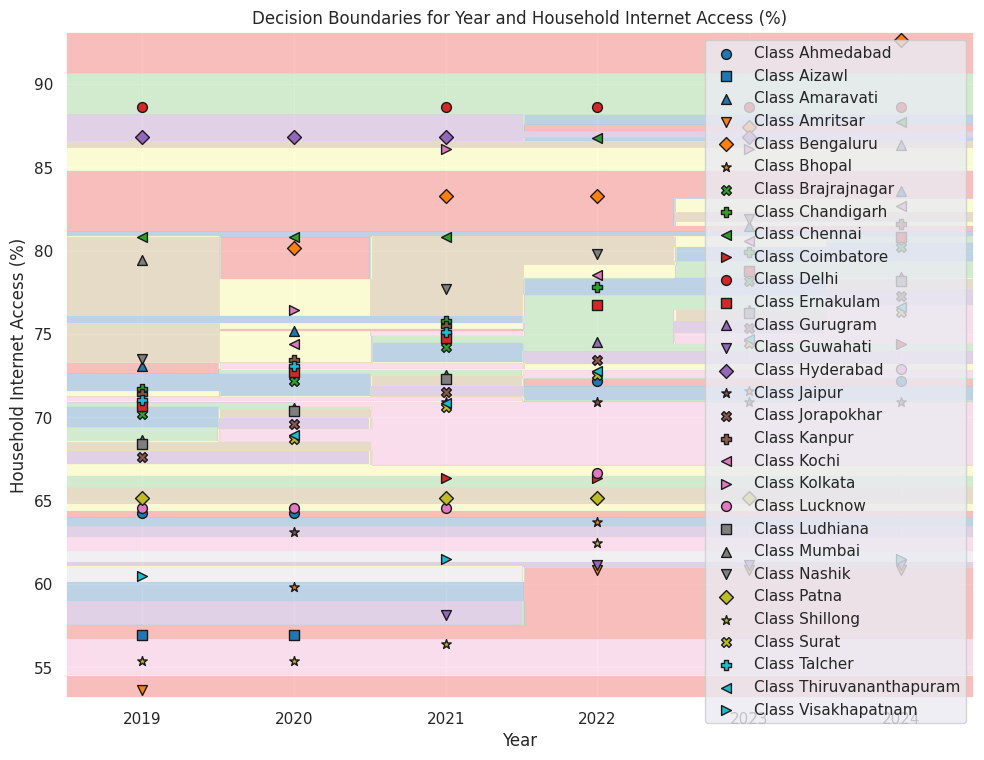

In [12]:
# Выбор двух признаков: Year и Household Internet Access (%)
X_subset = X[['Year', 'Household Internet Access (%)']]  # из полного набора данных выбираем 2 признака
feature_names = ['Year', 'Household Internet Access (%)']

# Разделение данных
X_train, X_test, y_train, y_test = train_test_split(X_subset, y, test_size=0.3, random_state=42)

# Генерация маркеров и цветов
answers = np.unique(y_train)  # Уникальные классы
plot_colors = plt.cm.tab10(np.linspace(0, 1, len(answers)))  # Динамическая палитра
plot_markers = ['o', 's', '^', 'v', 'D', '*', 'X', 'P', '<', '>']  # Запас маркеров

# Параметры построения
fmin = X_train.min() - 0.5 # Минимум для сетки с небольшим отступом
fmax = X_train.max() + 0.5 # Максимум для сетки с небольшим отступом
plot_step = 0.02 # Шаг сетки

# Создаем координатную сетку для отображения границ классификации.
xx, yy = np.meshgrid(
    np.arange(fmin[feature_names[0]], fmax[feature_names[0]], plot_step),
    np.arange(fmin[feature_names[1]], fmax[feature_names[1]], plot_step)
)

# Создаем и обучаем дерево решений
model = DecisionTreeClassifier(max_depth=optimal_depth, max_features=optimal_features, random_state=42)
model.fit(X_train, y_train)

# Преобразуем сетку координат в формат DataFrame.
grid_points = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()], columns=feature_names)
# Предсказываем классы для всех точек сетки.
predictions = model.predict(grid_points)

# Преобразуем предсказания в числовой формат
predictions_numeric = np.zeros_like(predictions, dtype=int)
for idx, label in enumerate(answers):
    predictions_numeric[predictions == label] = idx

# Формируем карту предсказаний
predictions_numeric = predictions_numeric.reshape(xx.shape)

# Построение графика, настраиваем размеры
plt.figure(figsize=(10, 8))
# Отображаем границы классификации как заливку цветами (contourf).
plt.contourf(xx, yy, predictions_numeric, cmap='Pastel1', alpha=0.8)

# Отображаем данные
# Перебираем классы (answers) с их порядковыми индексами.
for id_answer, answer in enumerate(answers):
  # Возвращает индексы, где условие истинно
    idx = np.where(y_train == answer)[0]  # Используем [0], чтобы извлечь индексы из кортежа
    plt.scatter(
        # Первые координаты, значения первого признака
        X_train.iloc[idx, 0], # iloc извлекает значения из X_train по индексам idx для первого и второго признака.
        # Вторые координаты, значения второго признака
        X_train.iloc[idx, 1],
        c=[plot_colors[id_answer]],
        label=f"Class {answer}", # Метка для текущего класса
        marker=plot_markers[id_answer % len(plot_markers)], # Маркер (форма точки) для текущего класса.
        edgecolor='k', # черный контур вокруг каждого маркера
        s=50 # размер точек
    )

# Подписи осей
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.title("Decision Boundaries for Year and Household Internet Access (%)")
plt.legend()
plt.tight_layout()
plt.show()
